# T51 Unsupervised learning - Capstone Project VII

## Exploring the data

In [3]:
# import libraries

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# load data
arrest_df = pd.read_csv('UsArrests.csv')
arrest_df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


First, I will clean the data set ready for the analysis. I rename columns so that it is clearer what they represent.

In [5]:
# change name of 'City' column to 'State'
d = {
    'City' : 'State',
    'Murder' : 'Murder arrests (per 100,000)',
    'Assault' : 'Assault arrests (per 100,000)',
    'UrbanPop' : 'Urban population (%)',
    'Rape' : 'Rape arrests (per 100,000)'
    }
arrest_df.rename(columns = d, inplace = True)

# set 'State' column as index
arrest_df.set_index('State', inplace=True)
arrest_df.head()

,"Murder arrests (per 100,000)","Assault arrests (per 100,000)",Urban population (%),"Rape arrests (per 100,000)"
State,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


I summarise the statistical properties of the columns. At first glance, I find that there is quite a large difference in the statistical properties for the arrest rates of different crimes: the mean for assault arrests is highest at 170.76 per 100,000 population, with a range of 45 to 337, compared to murder arrests being the lowest at 7.79 per 100,000 population, with a range of 0.8 to 17.4. The mean etc. for urban population percentage is also a lot higher than the values for murder and rape arrests - this is not surprising as these features are on different scales. Overall, this indicates that scaling the data will be useful to keep the assault arrests and urban population from impacting the analysis disproportionately.

In [6]:
# set the decimal precision to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# get the descriptive states for the data set
stats = arrest_df.describe()
# select relevant rows
selected_stats = stats.loc[["mean","std","min","max"]].transpose() 
selected_stats

,mean,std,min,max
"Murder arrests (per 100,000)",7.79,4.36,0.80,17.40
"Assault arrests (per 100,000)",170.76,83.34,45.00,337.00
Urban population (%),65.54,14.47,32.00,91.00
"Rape arrests (per 100,000)",21.23,9.37,7.30,46.00


I determine if the data set has any missing values, and which features these occur for. I find that the data set has no missing values.

In [7]:
# Count missing values
missing = arrest_df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
"Murder arrests (per 100,000)",0
"Assault arrests (per 100,000)",0
Urban population (%),0
"Rape arrests (per 100,000)",0


It is often useful to determine the type of each variable. I find that that I am working predominantly with continuous/numerical variables.

In [8]:
# determine data types for data set
arrest_df.dtypes

Murder arrests (per 100,000)     float64
Assault arrests (per 100,000)      int64
Urban population (%)               int64
Rape arrests (per 100,000)       float64
dtype: object

I plot a histogram to visualise the distribution of the observations for each feature. I find that the features generally do not have a normal distribution.

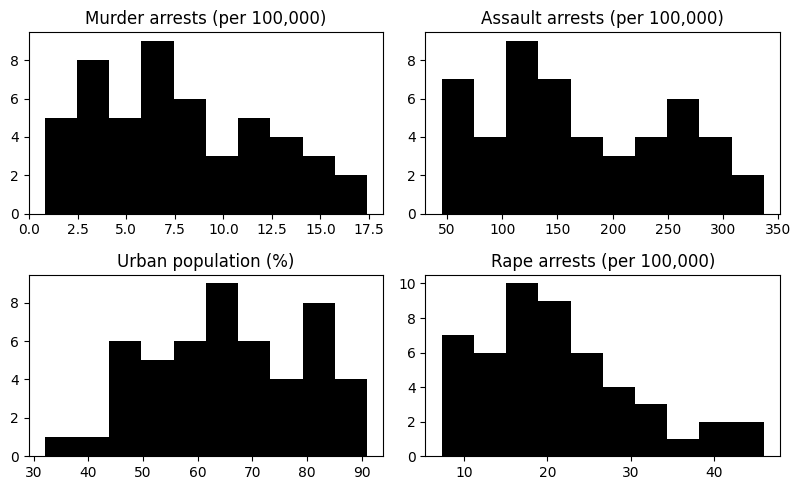

In [9]:
# Plot histograms
histograms = arrest_df.hist(color='black', grid=False, figsize=(8, 5))
plt.tight_layout()
plt.show()

## Correlation analysis

I also plot a pairplot to visualise both the distribution of the observations of each feature and the relationship between each pair of features. I find that the arrest rates for each crime are positively correlated with the arrest rates for the other crimes, that is as the arrest rate of one crime increases, the arrest rate for the other two crimes also tends to increase.

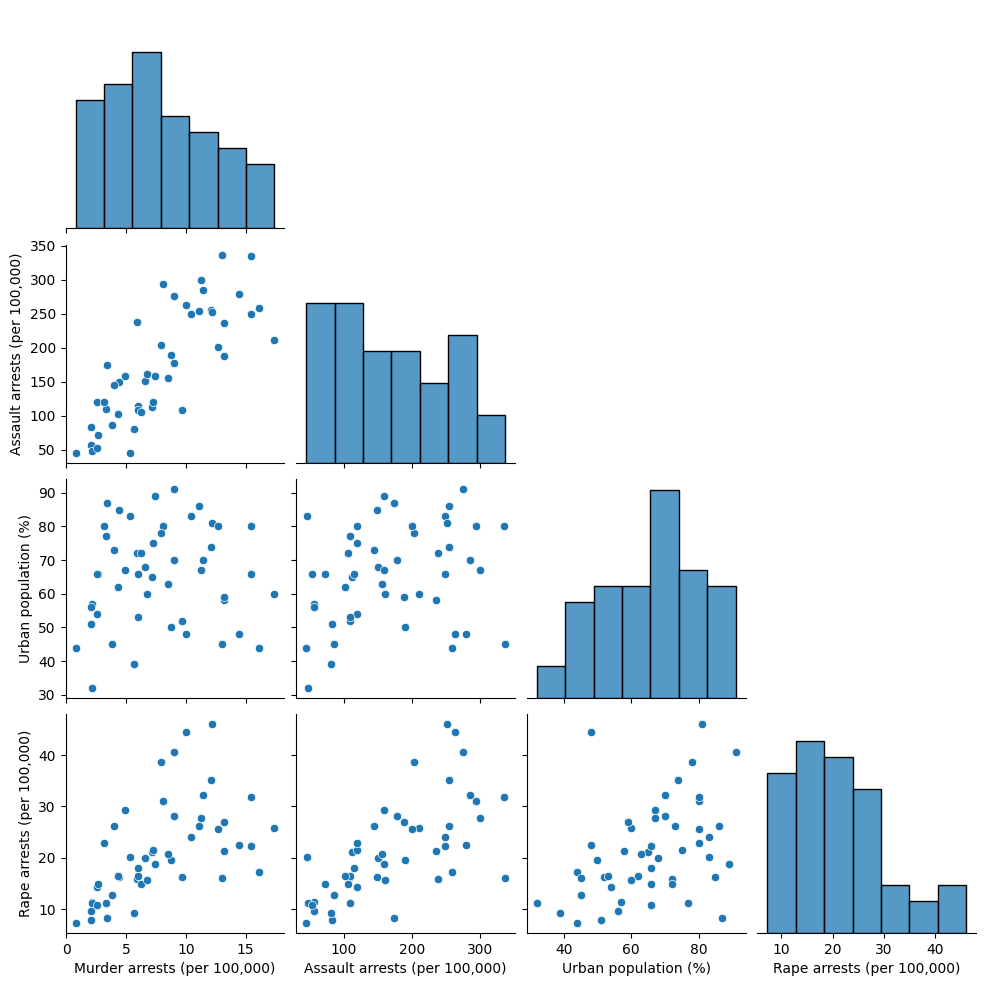

In [10]:
# create pairplot
sns.pairplot(arrest_df, corner=True)

I plot a heatmap to visualise the correlations (Pearson coefficient) between the different features. In the plot, there is a linear correlation between strongly correlated variables: those coloured in either dark red or dark blue. Variables which are positively correlated are red: an increase in one corresponds to an increase in the other, while negatively correlated variables are blue: a decrease in one means an increase in the other.

As suggested by the pair plot above, I find that the strongest correlations are between the arrest rates for different crimes. In particular, I find that assault arrests and murder arrests are very highly positively correlated. There is also a high positive correlation between assault arrests and rape arrests, and a moderate positive correlation between murder arrests and rape arrests. These correlations are intuitive - these are all violent crimes, whose incidence tends to be related.

I also find a moderate positive correlation between rape arrests and urban population and a weak positive correlation between assault arrests and urban population. Again, these correlations are intuitive - crime rates tend to be higher in urban, densely populated areas.

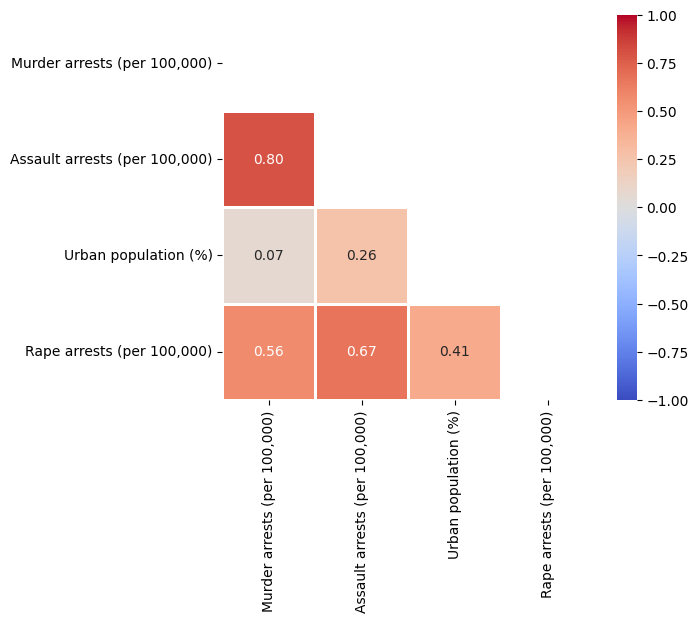

In [11]:
# calculate pairwise correlations for data set
corrs = arrest_df.corr()
fig, ax = plt.subplots(figsize=(6, 5))

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map, with annotations of the correlation strength
# and 2-decimal floats
ax = sns.heatmap(
    corrs, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", 
    mask=dropSelf, linewidth=2)

## PCA

Principal Components Analysis (PCA) is a method for finding the underlying variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out. Since the determination of the principal components is based on finding the direction that maximises the variance, variables with variance that are much higher than the other variables tend to dominate the analysis purely due to their scale. PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce these. 

### Unstandardised data

I calculate the standard deviation, proportion of variance explained and cumulative explained variance associated with each of the 4 components.

In [12]:
# calculate values for each component
# and create dataframe
np.set_printoptions(precision=2)

X = arrest_df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [13]:
# calculate standard deviation for each component
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [14]:
# calculate proportion of variance explained for each component
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [15]:
# calculate cumulative explained variance for each component
print(f"Cumulative Explained Variance: {np.cumsum(pca.explained_variance_)}")

Cumulative Explained Variance: [7011.11 7213.11 7255.22 7261.38]


In [16]:
# define function to create biplot of principal components

def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(
                coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), 
                color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(
                coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', 
                ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From the biplot below, I see that assault arrests per 100,000 population and urban population percentage are the most important features as the arrows to each of these dominate the biplot. These are the two features identified in my preliminary data exploration above as potentially impacting the analysis disproportionately due to differences in scale compared to the other features. It is difficult to see how states vary with respect to the other variables or read the biplot as lots of the states are overlapping.

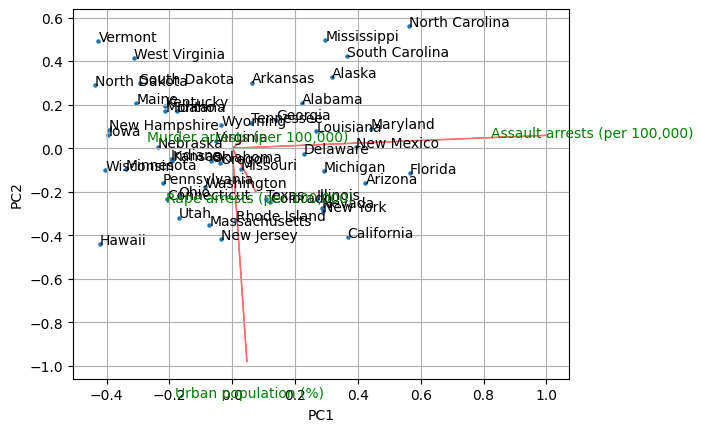

In [17]:
# create biplot of first two principal components
# using unstandardised data
states = arrest_df.index
labels = arrest_df.columns
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

This information can also be quantified as below. I see that the assault arrests per 100,000 population has by far the highest importance in the first principle component, while for the second component urban population percentage is the most important. These observations agree with those deduced from the biplot. Again, if I refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

In [18]:
# Feature importance
#change precision to see more decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

#components x features - access at index 0 to get the first component
pc1 = abs( pca.components_[0] ) 
pc2 = abs( pca.components_[1] )

# create dataframe showing feature importance
# for first two principal components against features
feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,"Murder arrests (per 100,000)",0.042,0.045
1,"Assault arrests (per 100,000)",0.995,0.059
2,Urban population (%),0.046,0.977
3,"Rape arrests (per 100,000)",0.075,0.201


### Standardised data

I standardise the data so that some features - namely assault arrests per 100,000 and urban population percentage - do not swamp the others.

In [19]:
# scale data
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

# create dataframe with scaled data
df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


When I plot the biplot again using the scaled data, I find that the standardised data results in far more balance in the variables being utilised to explain the variance, as the large numbers no longer dominate it.

The first principal component goes in a single direction, to the right, which shows the strength of the positive correlations found above. The variables with the largest positive loading values are the various arrest rates. This suggests that the first principal component summarises a general arrest/crime rate, with states with lower arrest/crime rates grouped to the left-hand side in the first principal component and states with higher arrest/crime rates grouped to the right-hand side.

The second principal component is dominated by urban population percentage.

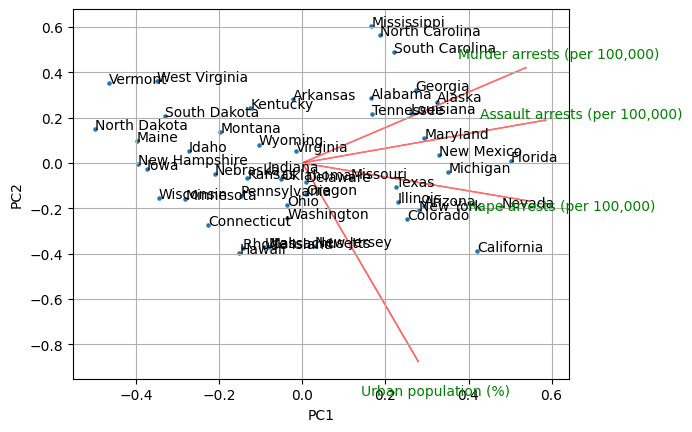

In [20]:
# create biplot of first two principal components
# using scaled data
biplot(
    X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

Inspecting the feature importance now, I see that the different variables contribute more evenly, although urban population percentage still dominates somewhat for the second component as indicated by the biplot immediately above.

In [21]:
# Feature importance
#components x features - access at index 0 to get the first component
pc1 = abs( std_pca.components_[0] ) 
pc2 = abs( std_pca.components_[1] )

# create dataframe showing feature importance
# for first two principal components against features using scaled data
feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,"Murder arrests (per 100,000)",0.536,0.418
1,"Assault arrests (per 100,000)",0.583,0.188
2,Urban population (%),0.278,0.873
3,"Rape arrests (per 100,000)",0.543,0.167


I see from the plots below that the first 2 principal components together explain over 85% of the variance. I can therefore use them to perform cluster analysis. This is what is referred to as dimensionality reduction. I began with 4 variables and now I have 2 variables explaining most of the variability. 

Text(0.5, 1.0, 'Cumulative Explained Variance')

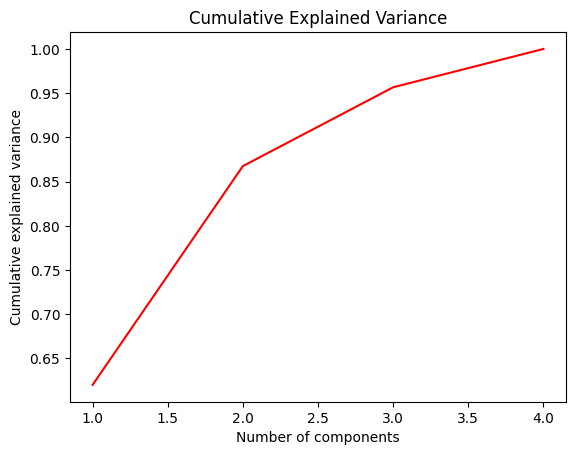

In [22]:
# Cumulative variance plot
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

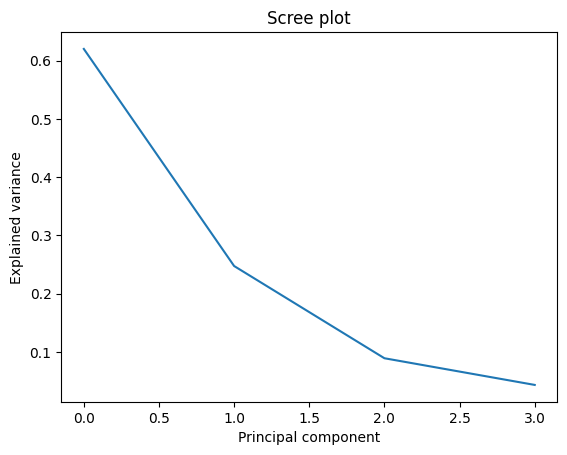

In [23]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.title("Scree plot")
plt.show()

In [24]:
# create data set with first two principal components
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = arrest_df.index)
pca_df.head()

,0,1
State,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


The heatmap below shows that the principal components are uncorrelated, showing that PCA has summarised all related information in a smaller number of variables.

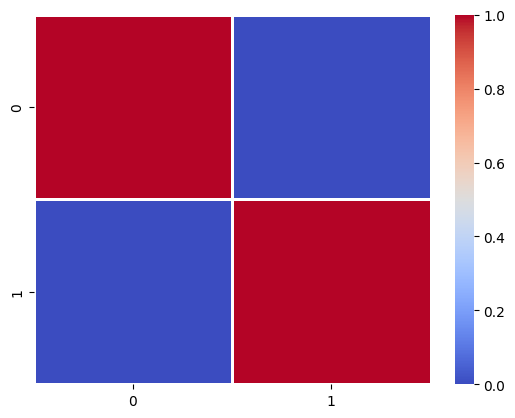

In [25]:
# create heatmap plot with Principal components
ax = sns.heatmap(pca_df.corr(), cmap='coolwarm', linewidth=1)
plt.show()

In [26]:
# determine 10 states with highest values for first principal component
highest_pc1_df = pca_df.nlargest(10, 0)
highest_pc1_df

,0,1
State,,
Florida,3.013,0.039
Nevada,2.874,-0.776
California,2.524,-1.543
Michigan,2.108,-0.155
New Mexico,1.980,0.143
Alaska,1.950,1.073
Maryland,1.763,0.428
Arizona,1.763,-0.746
New York,1.683,-0.823


In [27]:
# determine 10 states with lowest values for first principal component
lowest_pc1_df = pca_df.nsmallest(10, 0)
lowest_pc1_df

,0,1
State,,
North Dakota,-2.992,0.599
Vermont,-2.801,1.402
Maine,-2.397,0.376
New Hampshire,-2.384,-0.018
Iowa,-2.254,-0.104
West Virginia,-2.109,1.425
Wisconsin,-2.080,-0.611
South Dakota,-1.988,0.823
Minnesota,-1.693,-0.632


In [28]:
# determine 10 states with highest values for second principal component
highest_pc2_df = pca_df.nlargest(10, 1)
highest_pc2_df

,0,1
State,,
Mississippi,0.996,2.394
North Carolina,1.123,2.228
South Carolina,1.321,1.933
West Virginia,-2.109,1.425
Vermont,-2.801,1.402
Georgia,1.639,1.279
Alabama,0.986,1.133
Arkansas,-0.141,1.120
Alaska,1.950,1.073


In [29]:
# determine 10 states with lowest values for second principal component
lowest_pc2_df = pca_df.nsmallest(10, 1)
lowest_pc2_df

,0,1
State,,
Hawaii,-0.913,-1.570
California,2.524,-1.543
Rhode Island,-0.864,-1.492
Massachusetts,-0.486,-1.474
Utah,-0.551,-1.472
New Jersey,0.182,-1.450
Connecticut,-1.359,-1.089
Colorado,1.515,-0.988
Washington,-0.217,-0.970


## Clustering

### Hierarchical clustering

I will perform hierarchial clustering with the data set. Hierarchical clustering has the advantage that I can see the clusters visually in the dendrogram and don't have to specify the number of clusters before running the algorithm. However, I will need to decide the number of clusters after the algorithm runs.

In order to determine the method used to measure the distance between clusters, I plot the various dendrograms for the single, complete and average linkage methods. From the dendrograms below, I determine that the complete linkage method creates the most balanced dispersion of clusters and will therefore be the method of choice for the rest of this analysis.

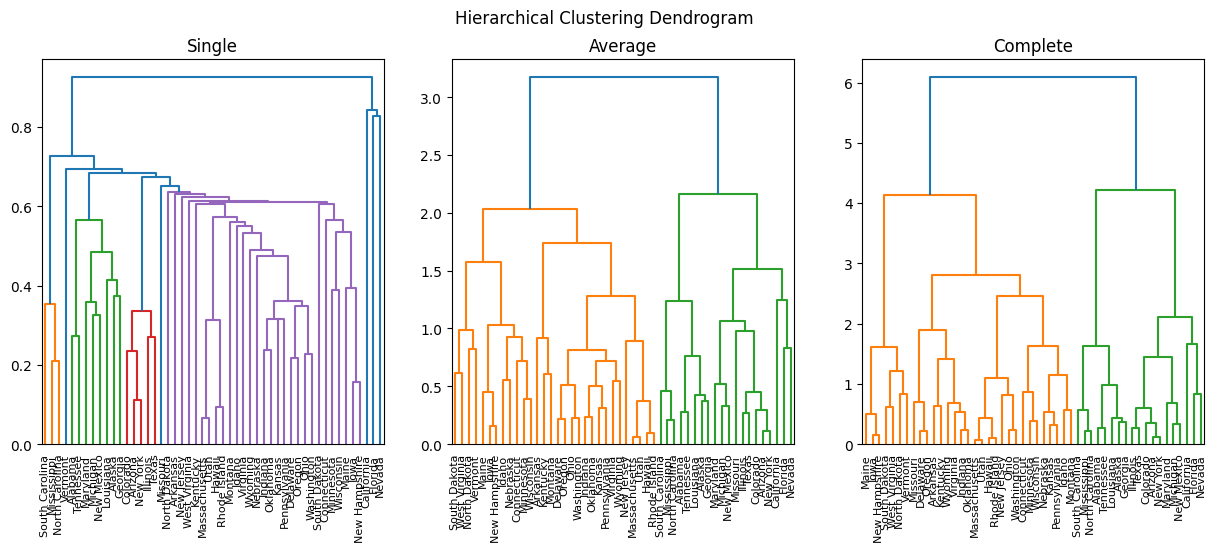

In [30]:
# create dendrograms 
# each using one of single, average and complete linkage methods
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1)
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

I plot a clearer dendrogram for the complete linkage method. With k=2, the clusters are of size 31 and 19 respectively. The clusters appear to correspond to the states with highest and lowest values for the first principal component as found above, with those states with a generally higher arrest/crime rate appearing in the green cluster and those states with a generally lower arrest/crime rate appearing in the orange cluster. This suggests the states are being clustered according to general arrest/crime rates. In other words, the way states have been clustered here closely mimics what I saw in the PCA above.

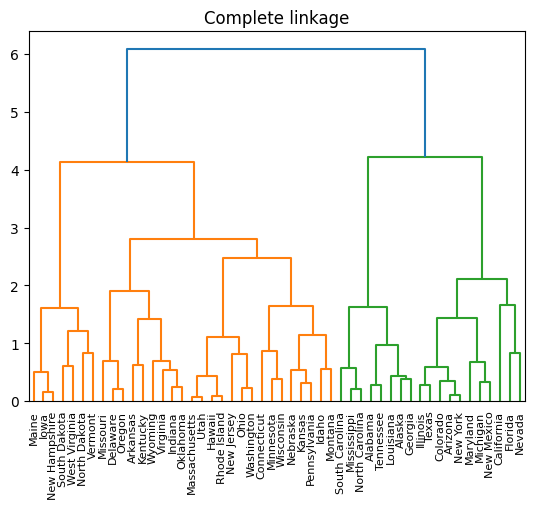

In [31]:
# create dendrogram using complete linkage method
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

### K-means clustering

K-means is a very popular clustering partitioning algorithm that is fast and efficient. It is an iterative process, so observatons can switch between clusters while the algoritm runs until it converges at a local optimum. There are some drawbacks to this method, however, including the necessity of specifying K in advance.

K will be set to 2, on the basis of the hierarchical clustering analysis above. A visualisation of the clusters is shown in the figure below.

I find that the two clusters very closely reflect the clusters produced in my hierarchal clustering above, the only difference being that Missouri has switched clusters. Again, this suggests the states are being clustered according to general arrest/crime rates, mimicking what I found in the PCA above.

However, I note that the silhouette score, which indicates the how similar samples within a cluster are compared to other clusters, is relatively low at 0.41. This suggests that the model is not strong. Increasing k to 3 lowers the silhouette score, incidating greater overlap of clusters, and so does not improve the model. I started with a limited number of features/variables - I believe that I could create a more robust model using a wider ranging data set, e.g. including arrest rates for both overall crime and a greater variety of crimes, including features describing other criminogenic factors.

Text(0, 0.5, 'Dim 1')

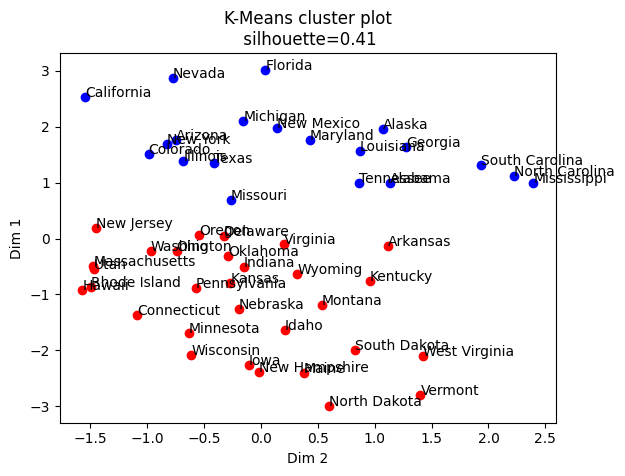

In [32]:
# We extract the first two components
x = X_std_trans[:,1]
y = X_std_trans[:,0]

# Fit k-means
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

# calculate silhouette score
score = round(
    silhouette_score(X_std_trans, kmeans.labels_, metric='euclidean'),2)

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot\n silhouette={}".format(score))
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

Text(0, 0.5, 'Dim 1')

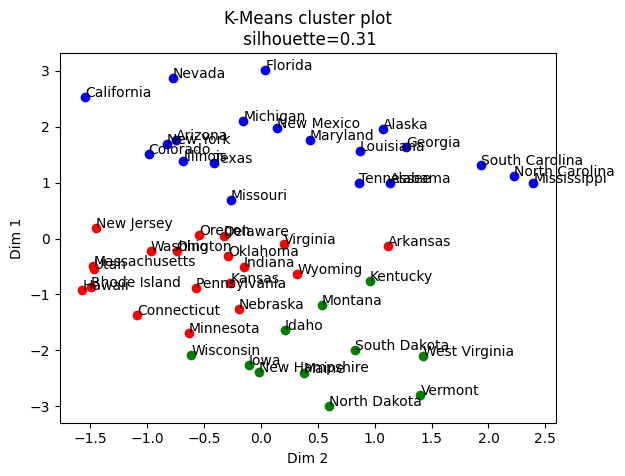

In [33]:
# Fit k-means
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

# calculate silhouette score
score = round(
    silhouette_score(X_std_trans, kmeans.labels_, metric='euclidean'),2)

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot\n silhouette={}".format(score))
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

## GitHub

I have pushed all the work that I have generated for this project to GitHub (https://github.com/VeeForrester)